## 1. Importamos Librerías importantes y la Data

**Usaremos una librería Ax para realizar varios experimentos o modelos basados en redes neuronales con el fín de conseguir los mejores parámetros e hiperparámetros que determinarán al mejor modelo. Además se probará el comportamiento de otros modelos no basados en redes neuronales**. 

In [1]:
# import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import sklearn.metrics as metrics  ##matriz de confusion
from  sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#usando las libreiras tradicionales
from sklearn.metrics import precision_recall_fscore_support
#import xgboost as xgb
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Ahora debemos importar las librerias de AX para poder realizar los experimentos!
#from ax.service.ax_client import AxClient
#from ax.utils.notebook.plotting import render, init_notebook_plotting # solo para graficar de otra manera!

## Limpieza de datos o EDA Básico

In [3]:
df= pd.read_csv("dataset_SCL.csv")
df_aux=pd.read_csv("dataset_SCL.csv")

C:\Users\diego\AppData\Local\Temp\ipykernel_7340\4293364141.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("dataset_SCL.csv")
C:\Users\diego\AppData\Local\Temp\ipykernel_7340\4293364141.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_aux=pd.read_csv("dataset_SCL.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [5]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [6]:
def clustering(df):
  d={}
  for columns in df:
    if columns=="MES":
      continue
    if columns=="temporada_alta":
      continue
    Cluster=df[columns].sort_values().unique().tolist()
    dc={}
    for i in range(len(Cluster)):
      df[columns].replace(Cluster[i],int(i),inplace=True)
      dc[i]= Cluster[i]
    d[columns]=dc
 
  return d, df

diccionario, df_aux= clustering(df_aux[['MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES']])

C:\Users\diego\AppData\Local\Temp\ipykernel_7340\1482172391.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns].replace(Cluster[i],int(i),inplace=True)


In [7]:
#diccionario

In [8]:
df_aux

,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,1,0,0,0,5,0,34
1,1,0,2,0,5,0,34
2,1,0,3,0,5,0,34
3,1,0,4,0,5,0,34
4,1,0,1,0,5,0,34
...,...,...,...,...,...,...,...
68201,12,0,6,0,14,0,28
68202,12,0,2,0,14,0,28
68203,12,0,4,0,14,0,28
68204,12,0,6,0,14,0,28


<Axes:>

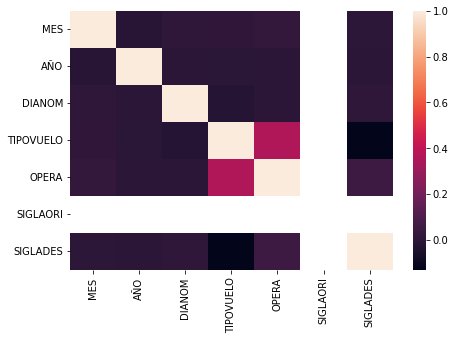

In [9]:
#################################CORRELACIÓN##############################
labels=['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLAORI', 'SIGLADES']
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.25, 0.35, 0.7, 0.6]) 
sns.heatmap(df_aux.corr(),xticklabels=labels,yticklabels=labels)

<Axes:>

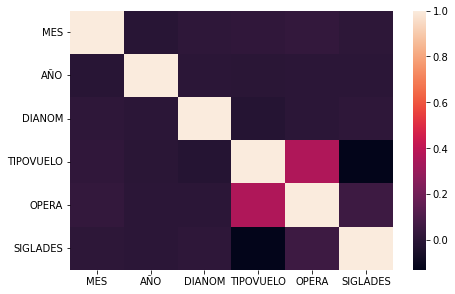

In [10]:
#Como SIGLAORI posee un único valor, podemos sacar este del dataset de entrenamiento de modelos. 
#No es de interés estudiar su correlación con las demás variables

#################################CORRELACIÓN##############################
labels=['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLADES']
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.25, 0.35, 0.7, 0.6]) 
sns.heatmap(df_aux[['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLADES']].corr(),xticklabels=labels,yticklabels=labels)

Text(0, 0.5, 'Varianza')

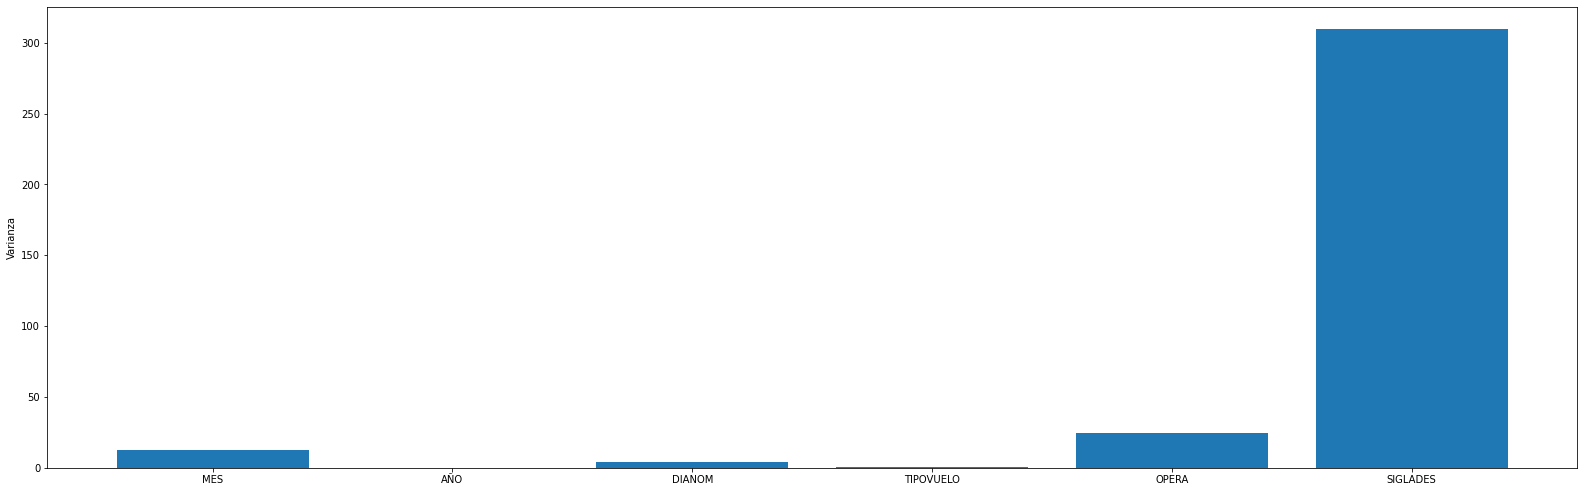

In [11]:
#######################################VARIANZA#################################
varianza=df_aux[['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLADES']].var(axis=0)
fig = plt.figure(figsize=(25,8))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8]) 
plt.bar(labels,varianza)
plt.ylabel('Varianza')

Text(0, 0.5, 'Varianza')

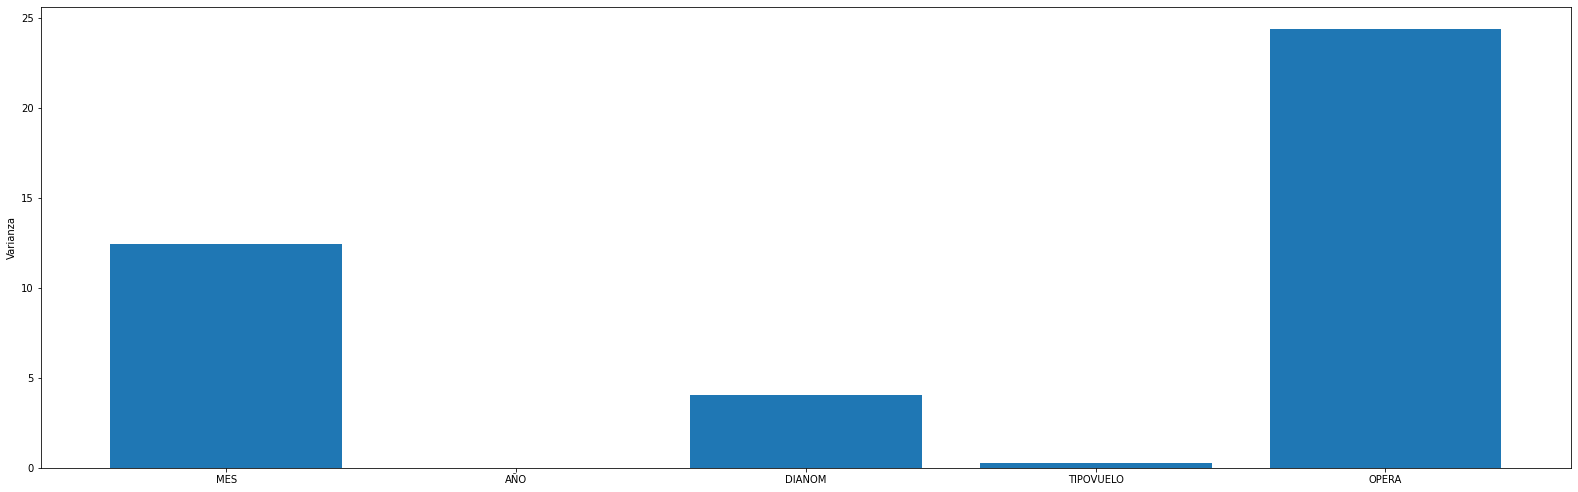

In [12]:
#######################################VARIANZA#################################
labels=['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA']
varianza=df_aux[['MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA']].var(axis=0)
fig = plt.figure(figsize=(25,8))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8]) 
plt.bar(labels,varianza)
plt.ylabel('Varianza')

Text(0, 0.5, 'Frequency')

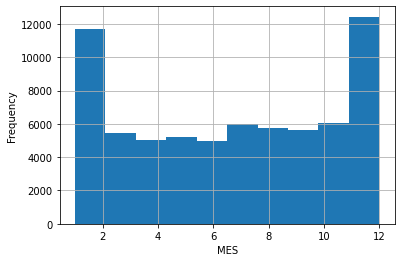

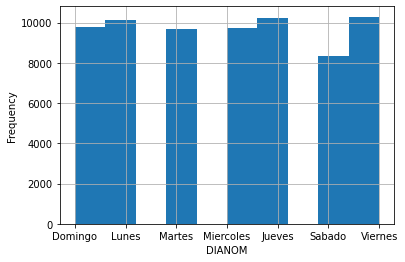

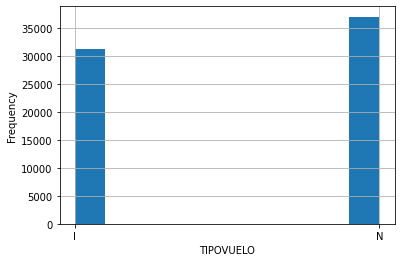

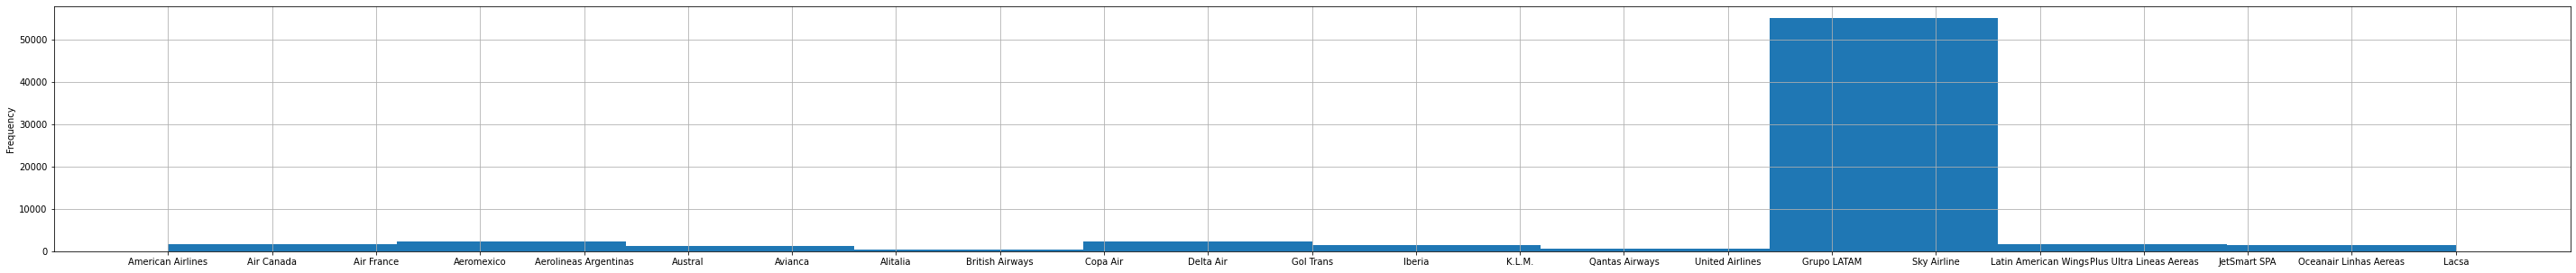

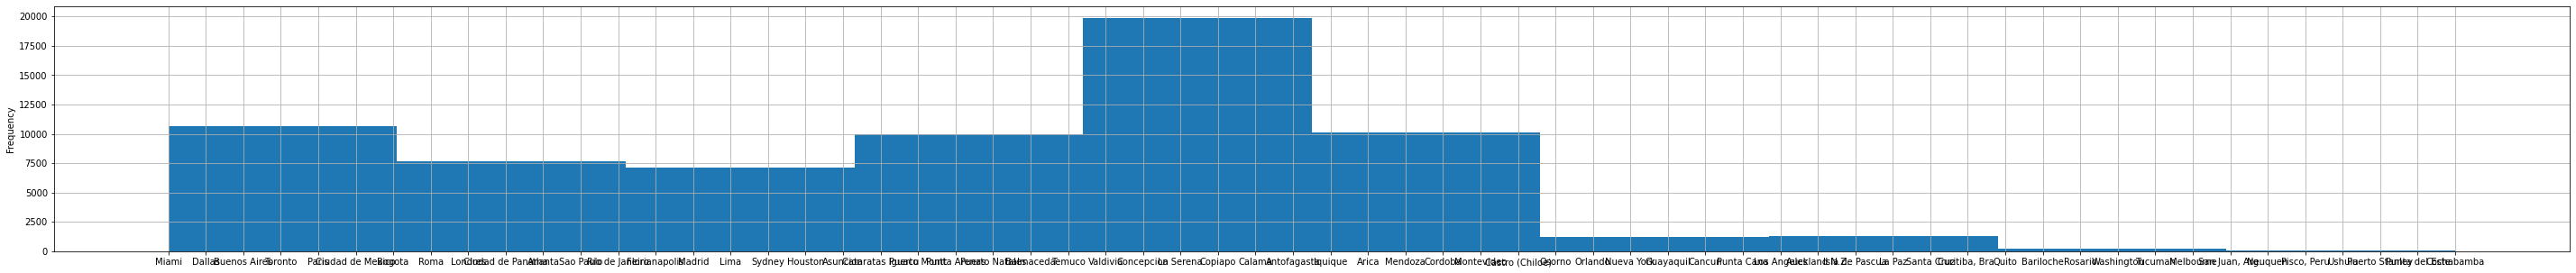

In [13]:
labels=['MES', 'DIANOM', 'TIPOVUELO']

for feature in labels:
    plt.figure()
    df[feature].hist()
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.figure(figsize=(50,5))
df['OPERA'].hist()
plt.ylabel('Frequency')

plt.figure(figsize=(50,5))
df['SIGLADES'].hist()
plt.ylabel('Frequency')

**P1** ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

Por la información entregada, no hay valores faltanes, es decir, el df está completo y no hay Nan values. Por otro lado, se estudian las principales columnas o features que podrían presentar alguna correlación, y en caso de haber altas correlaciones, eventualmente se pueden eliminar n-1 features altamente correlacionados. 

se crea un dataframe auxiliar para estudiar la correlación de las variables que potencialmente están correlacionadas, estas son
'MES', 'AÑO', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLAORI' y 'SIGLADES'. Cabe destacar que las fechas de programación de vuelo, operación y códigos no presentan un interés para estudiar correlaciones, pues no son variables que incidan en el retraso, por lo que se estima no trabajar con estas variables. 

Podemos observar que las variables de interés no están correlacionadas entre si, es más, la mayor correlación la tiene SIGLAORI, pues este posee un único valor que es santiago, como se puede ver en el diccionario. Por lo tanto esta variable puede ser eliminada del dataset de entrenamiento. 

Las variables poseen muy baja correlación. Por lo que modelos lineales de programación serían ineficientes para predecir si un vuelo se retrasa o no. 

Por otro lado, la varianza de la data de los features de interés es interesante. El año, al ser solo el 2017 y poco del 2018 posee poca incidencia en la data. Los meses, los días y las aerolíneas serían los features que nos interesan. Por otro lado, el tipo de vuelo podría no ser incidente, aunque se tomará en cuenta para evitar data sesgada. 

Finalmente, se puede concluir que, lógicamente, los meses con mayor cantidad de vuelos es Enero y Diciembre, que son las temporadas altas de santiaguinos, a demás de que la aerolínea con mayor cantidad de vuelos es Grupo LATAM y Sky Airlines. Por otro lado, la data distribuida entre 'días nominales' y 'tipo de vuelos' esta distribuida equitativamente. Por último, los destinos de los santiaguinos se comportan siguiendo una distribución normal a santiago, lo que es lógico, con la excepción de los viajes a miami, lo que podría marcar cierta tendencia de chilenos a vacacionar en ese lugar.

**P2** Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

1. temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
2. dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
3. atraso_15 : 1 si dif_min > 15, 0 si no.
4. periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
   Fecha-I .



In [14]:
#En primer lugar formateamos las fechas de las columnas que contienen fechas a datetime de pandas. 
df['Fecha-I']=pd.to_datetime(df['Fecha-I'])
df['Fecha-O']=pd.to_datetime(df['Fecha-O'])

In [15]:
############## Creación temporada_alta ##############

#En primer lugar, para mayor orden, creamos las fechas límites de las temporadas altas. 
a=pd.Timestamp('2016/12/15')
b=pd.Timestamp('2017/3/3')
c=pd.Timestamp('2017/7/15')
d=pd.Timestamp('2017/7/31')
e=pd.Timestamp('2017/9/11')
f=pd.Timestamp('2017/9/30')

#Luego, se crea la columna con las restricciones (usando las fechas a,b,c,d,e,f)
df.loc[((df['Fecha-I'] >=a)&(df['Fecha-I'] <=b)) ,'temporada_alta'] = 1
df.loc[((df['Fecha-I'] >=c)&(df['Fecha-I'] <=d)) ,'temporada_alta'] = 1
df.loc[((df['Fecha-I'] >=e)&(df['Fecha-I'] <=f)) ,'temporada_alta'] = 1
df['temporada_alta']=df['temporada_alta'].replace(np.nan,0) #Caso contrario, 0.



In [16]:
############## Creación dif_min ##############

#Primero convertimos todo a formato datetime de pandas, para luego usar álgebra de fechas creando una 
#columna nueva en el dataframe

df['Fecha-I']=pd.to_datetime(df['Fecha-I'])
df['Fecha-O']=pd.to_datetime(df['Fecha-O'])

df['dif_min']=(df['Fecha-O']-df['Fecha-I'])
df['dif_min']=abs(df['dif_min'].apply(lambda x: x.total_seconds()/60))

#df['dif_min'].head()

In [17]:
############## Creación atraso_15 ##############

#Creamos una nueva columna atraso_15 a partir de la condición de atraso. Si existe una diferencia de min (de la columna 
#recien creada) mayor a 15, entonces hay atraso (o 1). Caso contrario, no hay atraso (0).  
#OJO, que para un mejor costo computacional, se puede colocar un df[atraso_15].replace(np.nan, 0), pero se realiza así para
#mejor visualización de la restricción

df.loc[(df.dif_min <=15), 'atraso_15'] = 0
df.loc[(df.dif_min > 15), 'atraso_15'] = 1

In [18]:
############## Creación periodo_día ##############

#En primer lugar, se usa una columna auxiliar que indique la hora del día. 
df['hora']=df['Fecha-I'].apply(lambda x: x.time().hour)

#Luego, usamos estas mismas restricciones para indicar el periodo del día según el enunciado del problema.
df.loc[(df['hora']>=5)&(df['hora']<12),'periodo_dia'] = 'mañana'
df.loc[(df['hora']>=12)&(df['hora']<19),'periodo_dia'] = 'tarde'
df.loc[(df['hora']>=19)&(df['hora']<=23),'periodo_dia'] = 'noche'
df.loc[(df['hora']<5)&(df['hora']>=0),'periodo_dia'] = 'noche'


In [19]:
#Visualizamos el dataframe nuevo
#df.head()

#Guardamos estas nuevas columnas en el archivo synthetic_features.csv
Columnas_nuevas= df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]
Columnas_nuevas.to_csv('synthetic_features.csv', encoding='utf-8')

**P3** ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

In [20]:
#Podemos crear una función auxiliar que ahorre notación para todos los casos pedidos. La función tasa
#toma el dataframe, el nombre de la columna tratada como variable y la etiqueta del label, que servirá
#para nombrar el gráfico. 

#tasa toma 3 parámetros y no retorna nada. Sin embargo, realiza un bar plot de la tasa de atraso
#por feature pedido. 

def tasa(df,columna, etiqueta='Label'):
    label=[]
    tasa=[]
    for value in df[columna].unique():
        a=df[df[columna]==value]['atraso_15'].count()
        b=df[(df[columna]==value)&(df['atraso_15']==1)]['atraso_15'].count()
        if np.round(b/a,2)>=0.1:
            label.append(value)
            tasa.append(np.round(b/a,2))
    
    plt.figure(figsize=(30,8))
    plt.bar(label,tasa)
    plt.xlabel(etiqueta)
    plt.ylabel('Tasa de atraso')

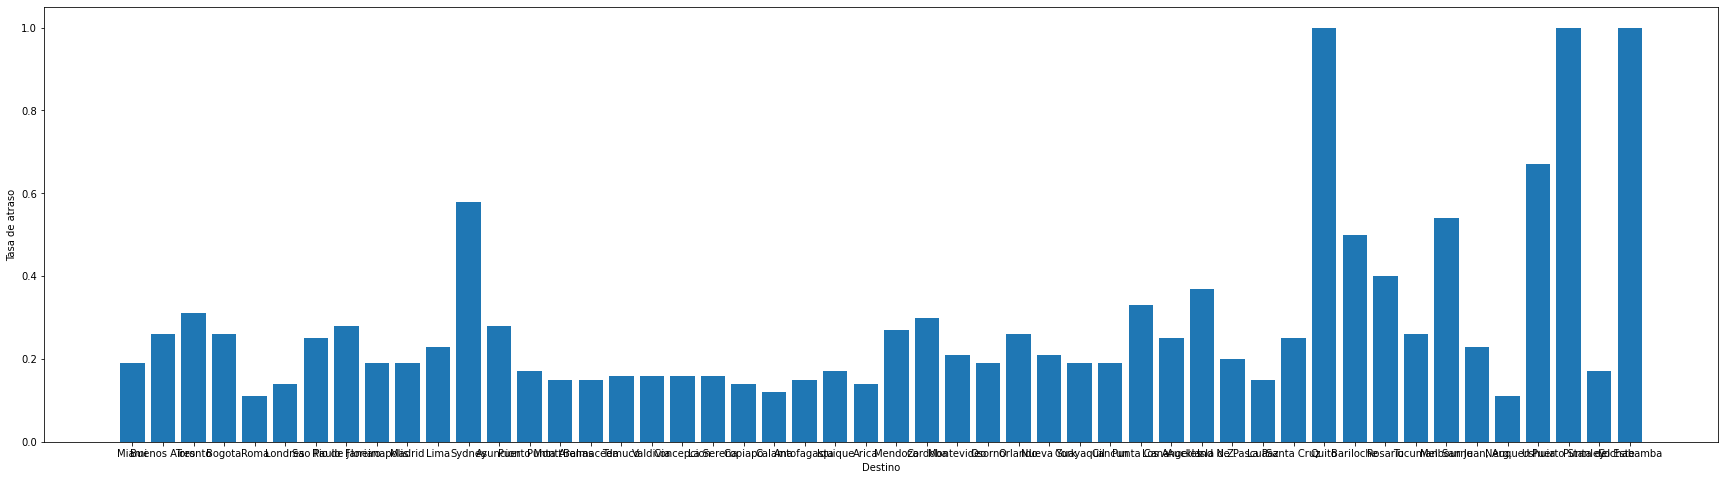

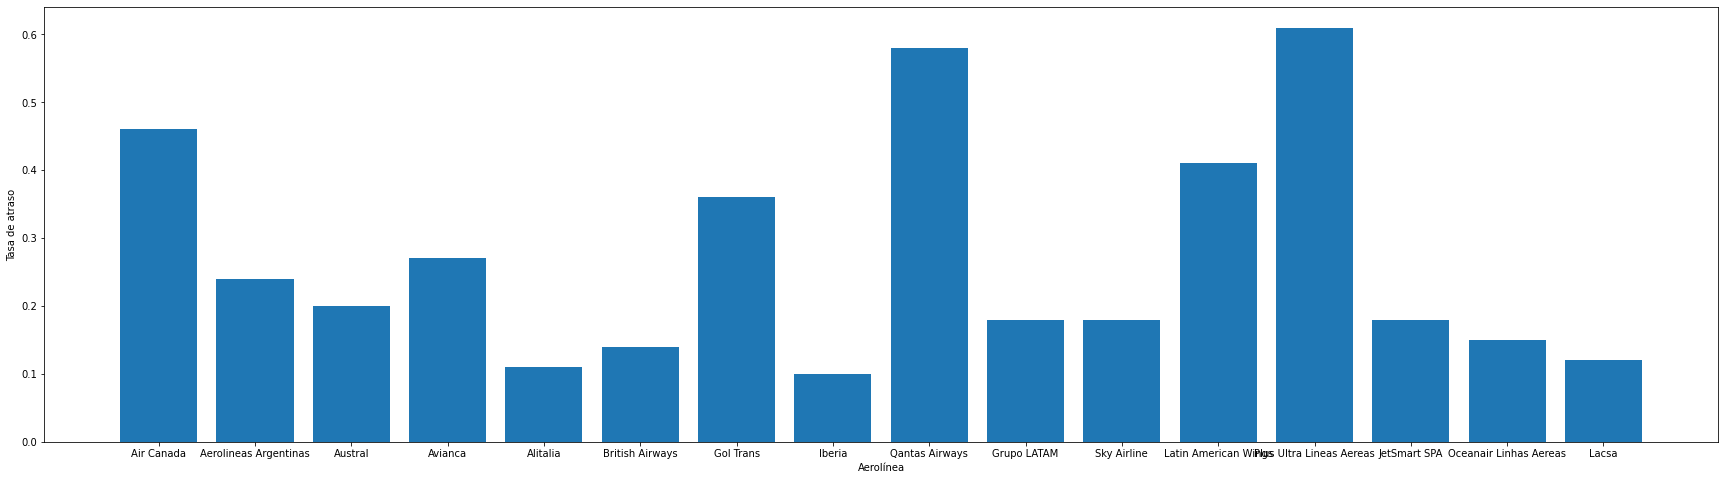

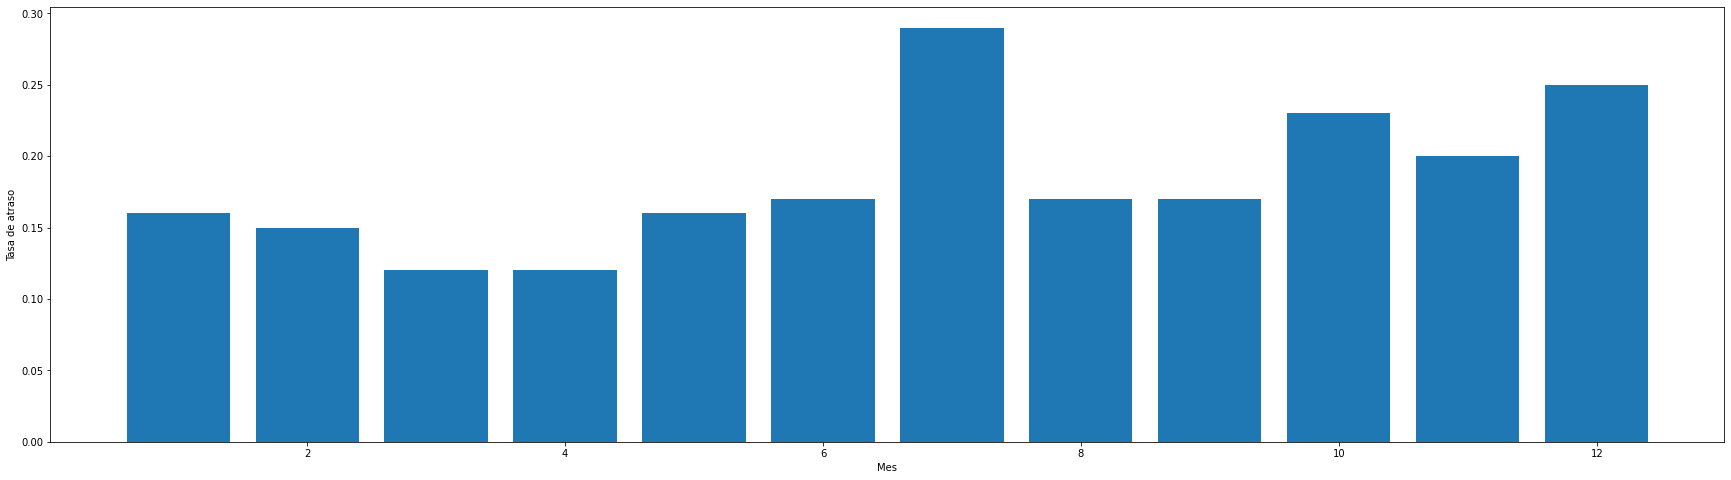

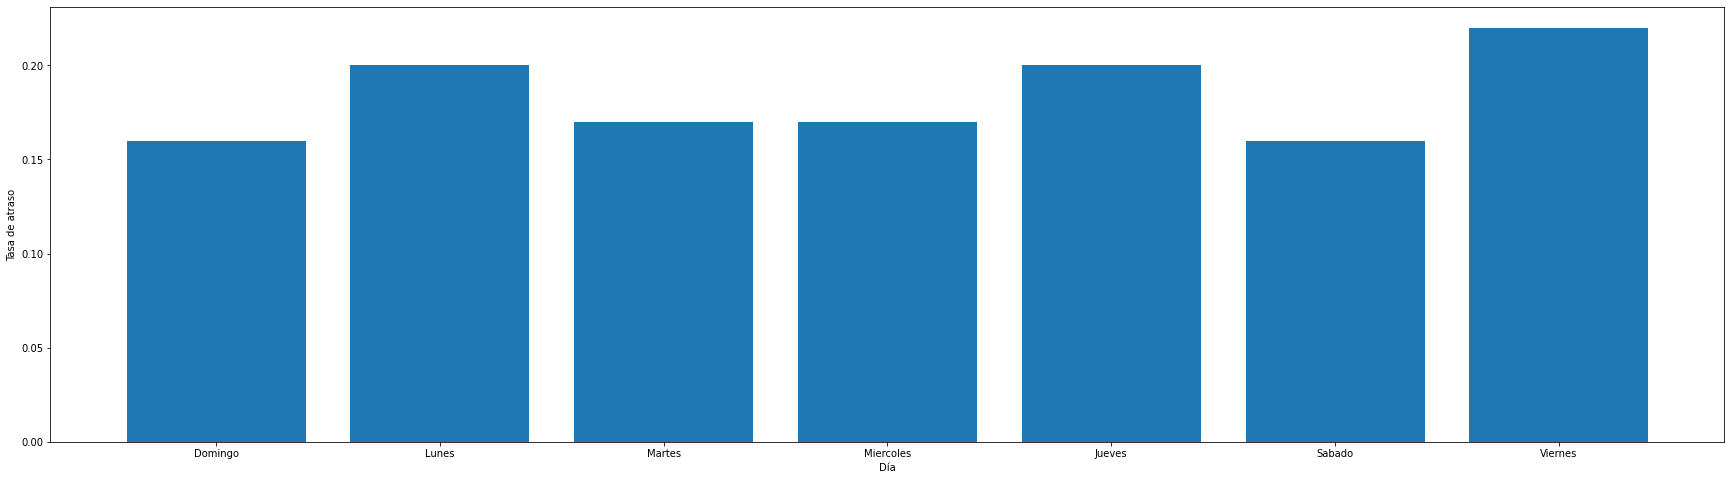

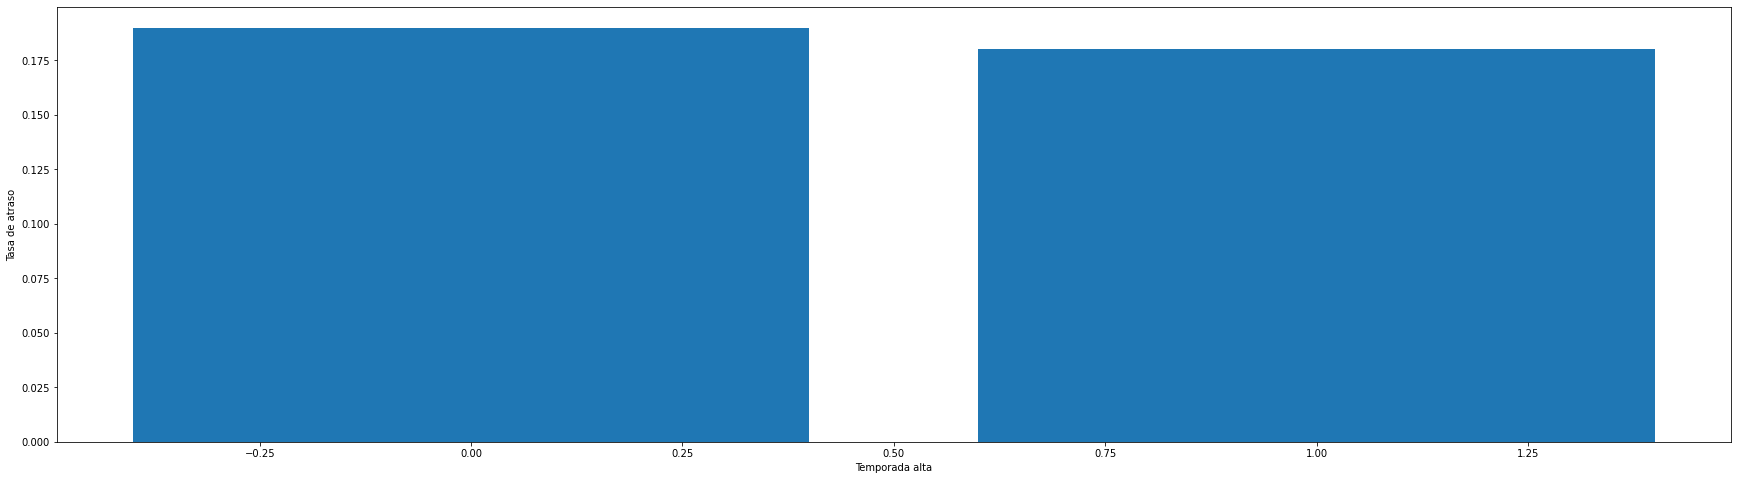

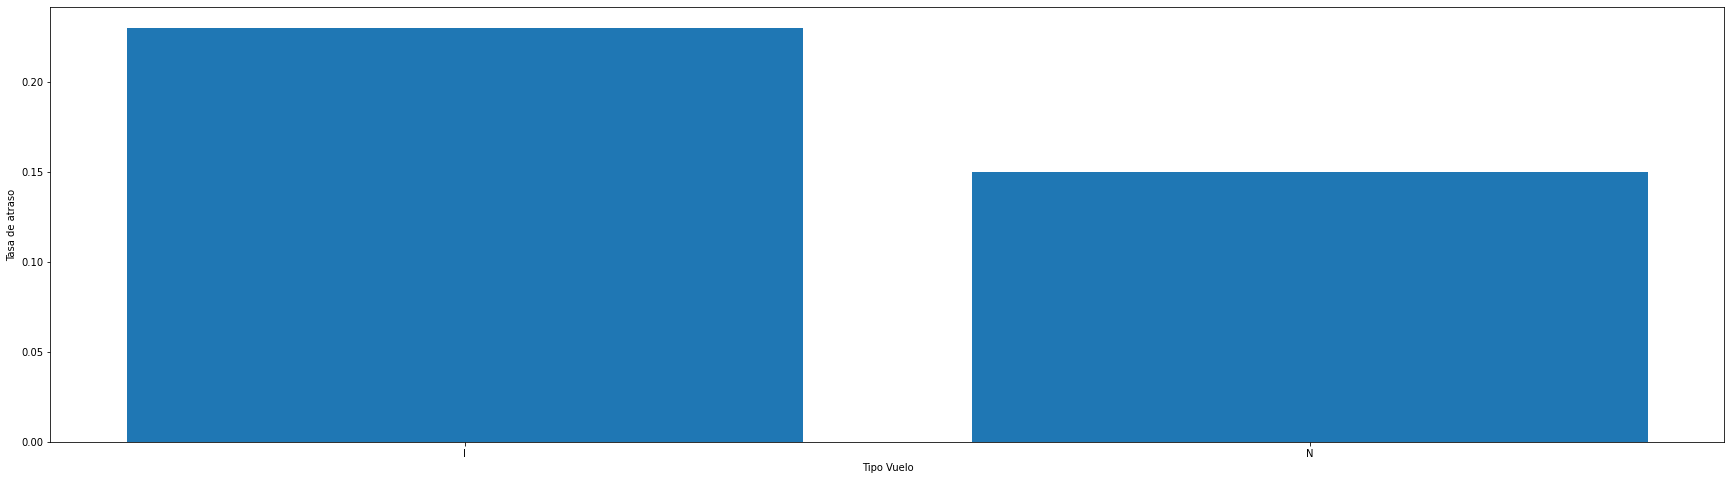

In [21]:
#Corremos la función para cada feature pedido
tasa(df,'SIGLADES','Destino')
tasa(df,'OPERA','Aerolínea')
tasa(df,'MES','Mes')
tasa(df,'DIANOM','Día')
tasa(df,'temporada_alta','Temporada alta')
tasa(df,'TIPOVUELO','Tipo Vuelo')

Se puede concluir que los features de interés, que es posible que incidan en retrasos de los vuelos son: 'MES', 'DIANOM', 'TIPOVUELO','OPERA','SIGLADES','temporada_alta', 'periodo_dia'. Esto, pues las demás variables que se nos entregan son fechas y códigos, y estos no son de nuestro interés, pues estas variables son diferentes para cada dato. Las fechas dadas fueron usadas para calcular el target, que son los atrasos. 

**P4** Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.


## 1 Crear Data de entrenamiento y validación

In [22]:
#Se carga la data con las columnas interesantes que podrían tener incidencia en el aprendizaje del modelo

X=df[['MES','DIANOM','TIPOVUELO','OPERA','SIGLADES','temporada_alta', 'periodo_dia']]
Y=df['atraso_15']
X

,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta,periodo_dia
0,1,Domingo,I,American Airlines,Miami,1.0,noche
1,1,Lunes,I,American Airlines,Miami,1.0,noche
2,1,Martes,I,American Airlines,Miami,1.0,noche
3,1,Miercoles,I,American Airlines,Miami,1.0,noche
4,1,Jueves,I,American Airlines,Miami,1.0,noche
...,...,...,...,...,...,...,...
68201,12,Viernes,I,JetSmart SPA,Lima,0.0,tarde
68202,12,Lunes,I,JetSmart SPA,Lima,0.0,tarde
68203,12,Miercoles,I,JetSmart SPA,Lima,0.0,tarde
68204,12,Viernes,I,JetSmart SPA,Lima,0.0,tarde


In [23]:
#Como existe data categórica, se crea una función auxiliar que convierta todos los strings en 
#numeros enteros. Esto con el fín de que el modelo ANN logre aprender. 

#La función clustering toma los valores u objects de las columnas del df (excepto el Mes y la temporada, pues ya son números)
#Los ordena y les asigna un valor númerico según su orden. Esta función entrega el df trabajado y un diccionario con
#los clusters asignados.

def clustering(df):
  d={}
  for columns in df:
    if columns=="MES":
      continue
    if columns=="temporada_alta":
      continue
    Cluster=df[columns].sort_values().unique().tolist()
    dc={}
    for i in range(len(Cluster)):
      df[columns].replace(Cluster[i],int(i),inplace=True)
      dc[i]= Cluster[i]
    d[columns]=dc
 
  return d, df

In [24]:
df_x,dx=clustering(X)

C:\Users\diego\AppData\Local\Temp\ipykernel_7340\1634076306.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns].replace(Cluster[i],int(i),inplace=True)


In [25]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network

# https://medium.com/@isalindgren313/transformations-scaling-and-normalization-420b2be12300

# Convertimos el target binario en 2 columnas. Esto con el fín de obtener 2 columnas que representen 
# La probabilidad de atraso de cada vuelo. Es decir, ambas columnas indicarán la probabilidad de ser
# atraso y probabilidad de no atraso. 

Y=Y.to_numpy()
Y=to_categorical(Y)
scaler = MinMaxScaler()
X= scaler.fit_transform(dx)

# Split the data set into training and testing. Como hay relativamente
# poca data, se realiza un split 90-10. 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=1)


## 2. Construcción de la Red Neuronal

In [26]:
#Se escogen los mejores parámetros de la red neuronal que se encontró en 
#"Optimización de parámetros de red neuronal". Esto se realizará en un script
#aparte debido a que las versiones de conda y pytorch son muy sensibles, 
#y es muy probable que estas versiones no sean compatibles en todos los 
#ambientes.

learning_rate= 0.01964102256053528
dropout_rate= 0.013256329917104442
num_hidden_layers= 3
num_neurons_per_layer= 10
batch_size= 128
activation= 'sigmoid'
optimizer= 'adam'

inputs = tf.keras.Input(shape=(X_train.shape[1],))  # input layer.
x = layers.Dropout(dropout_rate)(inputs) # dropout on the weights.
    
# Agregamos capas ocultas con dropout.
for i in range(num_hidden_layers):
    x = layers.Dense(num_neurons_per_layer, activation=activation)(x)
    x = layers.Dropout(dropout_rate)(x)

# Creamos la capa de salida
# Tiene dos neuronas de salida porque mis datos target, son dos columnas.
# Como es un problema de clasificación utilizo softmax que llevará los pesos a una probabilidad.
# Lo que al predecir podremos llevar facilmente a una sola columna y luego calcular matriz de confusion.
# Esta capa no lleva dropout, logicamente. 

outputs = layers.Dense(2, activation='softmax')(x)

##Finalmente, en esta linea construyo el modeo que esta secuencialmente conectado y tiene dropout
model = tf.keras.Model(inputs=inputs, outputs=outputs)

NUM_EPOCHS = 30

# Specify the training configuration.
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse','accuracy'])

data = X_train
labels = Y_train

hist = model.fit(data, labels, epochs=NUM_EPOCHS, batch_size=batch_size, validation_split = 0.2)

Epoch 1/30
405/405 [==============================] - 4s 5ms/step - loss: 0.1520 - mse: 0.1520 - accuracy: 0.8159 - val_loss: 0.1521 - val_mse: 0.1521 - val_accuracy: 0.8129
Epoch 2/30
405/405 [==============================] - 2s 4ms/step - loss: 0.1502 - mse: 0.1502 - accuracy: 0.8159 - val_loss: 0.1519 - val_mse: 0.1519 - val_accuracy: 0.8129
Epoch 3/30
405/405 [==============================] - 1s 3ms/step - loss: 0.1499 - mse: 0.1499 - accuracy: 0.8159 - val_loss: 0.1515 - val_mse: 0.1515 - val_accuracy: 0.8129
Epoch 4/30
405/405 [==============================] - 1s 3ms/step - loss: 0.1491 - mse: 0.1491 - accuracy: 0.8159 - val_loss: 0.1504 - val_mse: 0.1504 - val_accuracy: 0.8129
Epoch 5/30
405/405 [==============================] - 2s 4ms/step - loss: 0.1483 - mse: 0.1483 - accuracy: 0.8159 - val_loss: 0.1500 - val_mse: 0.1500 - val_accuracy: 0.8129
Epoch 6/30
405/405 [==============================] - 2s 4ms/step - loss: 0.1480 - mse: 0.1480 - accuracy: 0.8159 - val_loss: 0.14

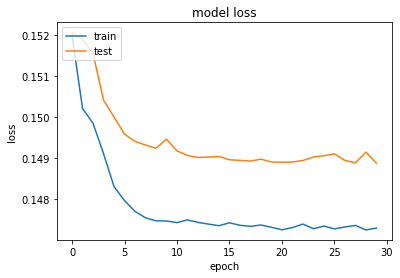

In [27]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

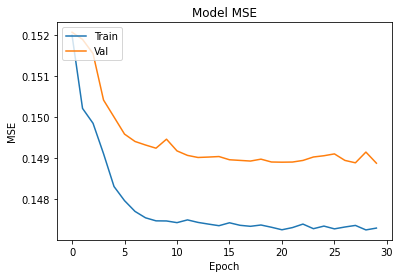

In [28]:
# Visualize the model's accuracy
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show


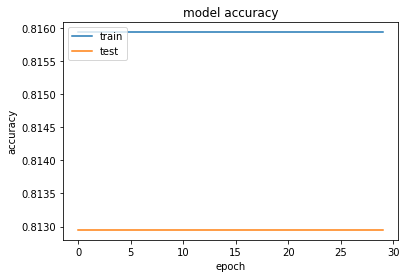

In [29]:
# summarize history for loss
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# Use the model to predict the test values.
test_pred = model.predict(X_test)


### Ahora, llevamos los valores de la prediccion a 0s y 1s (dado que usamos softmax)
test_pred[test_pred <= 0.5] = 0
test_pred[test_pred > 0.5] = 1

#Ahora debemos llevar la prediccion a una sola columna
test_pred_1col = np.argmax(test_pred, axis=1, out=None)
y_test_1col = np.argmax(Y_test,axis=1, out=None)

## Ahora tenemos nuestros valores de dos columnas, en 1 columna.. i.e. [1 0] pasa a [0] (es clase 0) y [0 1] pasa a [1] )(es clase 1)
#print(test_pred_1col)
#print(y_test_1col)

## Finalmente calculamos la matriz de confusion
print("Matriz de confusión del mejor modelo:\n")
matriz_cf = metrics.confusion_matrix(y_test_1col,test_pred_1col, labels=[0,1])
print(matriz_cf)

Matriz de confusión del mejor modelo:

[[2762    0]
 [ 649    0]]


In [31]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns


##Parametro
n_clases = 2

print("Precision total:", precision_macro_average(matriz_cf))
print("Recall total:", recall_macro_average(matriz_cf))


print("\nClase precision recall")
for label in range(n_clases):
    print(f"{label:5d} {precision(label, matriz_cf):9.3f} {recall(label, matriz_cf):6.3f}")

Precision total: nan
Recall total: 0.5

Clase precision recall
    0     0.810  1.000
    1       nan  0.000


C:\Users\diego\AppData\Local\Temp\ipykernel_7340\2661052747.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_matrix[label, label] / col.sum()


In [32]:
#usando las libreiras tradicionales
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test_1col, test_pred_1col, average='macro')

C:\Users\diego\anaconda3\envs\new_blackone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4048666080328349, 0.5, 0.44743236675846426, None)

## Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=42)

In [34]:
print("Train Accuracy RF : "+str(rf.score(X_train, Y_train)))
# Imprimo el accuracy del modelo.
print("\n.. y como se comportarán sobre datos nuevos!")
print("Test Accuracy RF : "+str(rf.score(X_test, Y_test)))

Train Accuracy RF : 0.8153406898680454

.. y como se comportarán sobre datos nuevos!
Test Accuracy RF : 0.8097332160656698


In [35]:
# Use the model to predict the test values.
test_pred = rf.predict(X_test)

### Ahora, llevamos los valores de la prediccion a 0s y 1s (dado que usamos softmax)
test_pred[test_pred <= 0.5] = 0
test_pred[test_pred > 0.5] = 1

#Ahora debemos llevar la prediccion a una sola columna
test_pred_1col = np.argmax(test_pred, axis=1, out=None)
y_test_1col = np.argmax(Y_test,axis=1, out=None)

## Ahora tenemos nuestros valores de dos columnas, en 1 columna.. i.e. [1 0] pasa a [0] (es clase 0) y [0 1] pasa a [1] )(es clase 1)

## Finalmente calculamos la matriz de confusion
print("Matriz de confusión del modelo Random Forest:\n")
matriz_cf = metrics.confusion_matrix(y_test_1col,test_pred_1col, labels=[0,1])
print(matriz_cf)

Matriz de confusión del modelo Random Forest:

[[2762    0]
 [ 649    0]]


**P5** Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

El modelo basado en redes neuronales tiene buen performance, posee alto accuracy de entrenamiento y validación, alto recall y bajo loss. Además, es no es costoso computacionalmente correr el modelo. Las métricas usadas fueron matriz de confusión que nos entregá los parámetros de precision, recall, y fscore. Estos porque son distintas métricas para evaluar la precisión del modelo y su sensibilidad. 

Escogí el algoritmo basado en redes neuronales puesto que, en general, supera a modelos no basados en redes neuronales en cuanto a predicciones, superando incluso modelos probabilisticos como Naive Bayes. Por otro lado escogí random forest como modelo no basado en rede neuronales porque en lo personal, es el que se comporta mejor en todos los modelos en general.  

Las varibles que más afectan en la predicción son MES, OPERA y SIGLADES. 

La performance del modelo podría mejorarse aumentando la data de entrenamiento, puesto que la entregada es relativamente poca para modelos de predicción de este estilo. 
